In [1]:
from pykalman import KalmanFilter
import numpy as np
import pandas as pd
import sys
import matplotlib
import matplotlib.pyplot as plt
from skimage.color import lab2rgb
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import GaussianNB
import skimage
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import FunctionTransformer
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from functools import reduce
import statsmodels.api as sm
lowess = sm.nonparametric.lowess
from scipy import stats

C:\Users\Matthew\Anaconda3\lib\site-packages\statsmodels\compat\pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


In [2]:
def to_timestamp(dateTime):
    return dateTime.timestamp()

def map_genre(row):
    result = []
    for genre_code in row:
        matches = genres[genres['wikidata_id'] == genre_code]['genre_label'].values
        for match in matches:
            result.append(match)
    return result

In [3]:
wikidata = pd.read_json('movies/data/wikidata-movies.json.gz', orient='record', lines=True, encoding="utf8", convert_dates=['publication_date'])
#wikidata = pd.read_json('movies/data/wikidata-movies.json.gz', orient='record', lines=True, encoding="utf8")
genres = pd.read_json('movies/data/genres.json.gz', orient='record', lines=True, encoding="utf8")

In [4]:
wikidata = wikidata[wikidata['made_profit'].notnull()].reset_index(drop=True)

In [5]:
#movies = movies.copy() #from https://stackoverflow.com/questions/31468176/setting-values-on-a-copy-of-a-slice-from-a-dataframe?rq=1
#movies['genre_names'] = movies.apply(map_genre,axis=1)
wikidata['genre_names'] = wikidata['genre'].apply(map_genre)
wikidata['publication_timestamp'] = wikidata['publication_date'].apply(to_timestamp)

In [6]:
rotten_tomatoes = pd.read_json('movies/data/rotten-tomatoes.json.gz', orient='record', lines=True)

In [7]:
#rotten_tomatoes
rotten_tomatoes.columns

Index(['audience_average', 'audience_percent', 'audience_ratings',
       'critic_average', 'critic_percent', 'imdb_id', 'rotten_tomatoes_id'],
      dtype='object')

In [8]:
omdb = pd.read_json('movies/data/omdb-data.json.gz', orient='record', lines=True)

In [9]:
#omdb

In [10]:
combined = wikidata.join(rotten_tomatoes.set_index('rotten_tomatoes_id'), on='rotten_tomatoes_id', rsuffix='_rt')

In [11]:
combined = combined.join(omdb.set_index('imdb_id'), on='imdb_id')

In [12]:
combined

,based_on,cast_member,country_of_origin,director,enwiki_title,filming_location,genre,imdb_id,label,made_profit,...,publication_timestamp,audience_average,audience_percent,audience_ratings,critic_average,critic_percent,imdb_id_rt,omdb_awards,omdb_genres,omdb_plot
0,NaN,"[Q5126010, Q3390414, Q5676024, Q237021]",Q29,[Q51892574],Orbiter 9,NaN,"[Q24925, Q21010853]",tt3469798,Orbiter 9,0.0,...,1.491523e+09,3.1,41.0,60.0,5.5,60.0,tt3469798,2 nominations.,"[Drama, Romance, Sci-Fi]",Helena is a young girl who spent all her life ...
1,NaN,NaN,Q30,"[Q3384479, Q351884]",Despicable Me,NaN,[Q157443],tt1323594,Despicable Me,1.0,...,1.276992e+09,NaN,NaN,NaN,NaN,NaN,tt1323594,Nominated for 1 Golden Globe. Another 3 wins &...,"[Animation, Adventure, Comedy]",In a happy suburban neighborhood surrounded by...
2,NaN,"[Q386349, Q1605965, Q3805579, Q271162, Q463226...",Q30,[Q2071],Eraserhead,[Q99],"[Q130232, Q200092, Q5967378]",tt0074486,Eraserhead,1.0,...,2.209248e+08,3.9,83.0,57175.0,8.3,91.0,tt0074486,2 wins & 1 nomination.,[Horror],A film that defies conventional logic and stor...
3,Q17017426,"[Q117500, Q1376880, Q11930, Q311169, Q951634, ...",Q30,[Q11930],Dances with Wolves,[Q1558],"[Q130232, Q369747, Q21590660, Q21010853, Q319221]",tt0099348,Dances with Wolves,1.0,...,6.581088e+08,3.6,87.0,213360.0,7.5,82.0,tt0099348,Won 7 Oscars. Another 43 wins & 37 nominations.,"[Adventure, Drama, Western]",Lt. John Dunbar is dubbed a hero after he acci...
4,NaN,"[Q38111, Q211553, Q177311, Q8927, Q173399, Q20...",Q145,[Q25191],Inception,"[Q99, Q387047, Q17, Q90, Q1951, Q7275217, Q126...","[Q496523, Q471839, Q2484376, Q188473, Q319221]",tt1375666,Inception,1.0,...,1.278547e+09,4.2,91.0,568239.0,8.1,86.0,tt1375666,Won 4 Oscars. Another 152 wins & 204 nominations.,"[Action, Adventure, Sci-Fi]","Dom Cobb is a skilled thief, the absolute best..."
5,NaN,"[Q229313, Q445772, Q727988, Q3163137, Q1372392...",Q16,[Q6385039],Mama (2013 film),"[Q172, Q133116, Q13939]",[Q200092],tt2023587,Mama,1.0,...,1.358381e+09,3.4,55.0,143566.0,6.0,65.0,tt2023587,11 wins & 18 nominations.,"[Horror, Thriller]","The senior partner of an investment brokerage,..."
6,Q243556,"[Q34012, Q41163, Q95043, Q464714, Q171736, Q32...",Q30,[Q56094],The Godfather,"[Q18438, Q60, Q1408, Q1460]","[Q130232, Q959790, Q7444356, Q21010853, Q52162...",tt0068646,The Godfather,1.0,...,6.946560e+07,4.4,98.0,731426.0,9.3,98.0,tt0068646,Won 3 Oscars. Another 24 wins & 28 nominations.,"[Crime, Drama]",When the aging head of a famous crime family d...
7,NaN,"[Q483118, Q23547, Q108283, Q215072, Q270664, Q...",Q30,[Q483118],Argo (2012 film),"[Q406, Q65, Q43]","[Q622291, Q18620604]",tt1024648,Argo,1.0,...,1.325376e+09,4.2,90.0,207900.0,8.4,96.0,tt1024648,Won 3 Oscars. Another 94 wins & 152 nominations.,"[Biography, Drama, Thriller]","In 1979, the American embassy in Iran was inva..."
8,Q7857661,"[Q317343, Q57147, Q244674, Q343616, Q208649, Q...",Q145,[Q706475],12 Years a Slave (film),[Q34404],"[Q130232, Q645928, Q52162262]",tt2024544,12 Years a Slave,1.0,...,1.377821e+09,4.3,90.0,139374.0,8.9,96.0,tt2024544,Won 3 Oscars. Another 235 wins & 326 nominations.,"[Biography, Drama, History]",Based on an incredible true story of one man's...
9,NaN,"[Q295803, Q200534, Q228865, Q200405, Q314133, ...",Q145,[Q191755],Only Lovers Left Alive,"[Q183, Q365]","[Q130232, Q1054574, Q2137852]",tt1714915,Only Lovers Left Alive,1.0,...,1.369440e+09,3.8,75.0,21114.0,7.4,85.0,tt1714915,9 wins & 42 nominations.,"[Comedy, Drama, Fantasy]","Adam (Tom Hiddleston), an underground musician..."


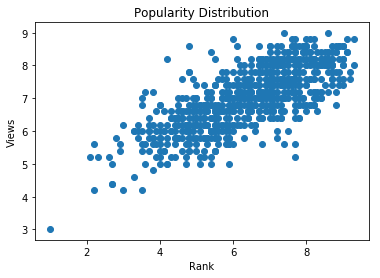

In [13]:
plt.title('Popularity Distribution')
plt.xlabel('Rank')
plt.ylabel('Views')
plt.scatter(combined['critic_average'], combined['audience_average'] * 2)
plt.show()

In [14]:
test3 = combined[combined['audience_average'].notnull() & combined['critic_average'].notnull()]
print(stats.normaltest(test3['audience_average']).pvalue) #<0.05, therefore not normal
print(stats.mannwhitneyu(test3['critic_average'], test3['audience_average'] * 2).pvalue) #>0.05, therefore one distribution is higher than the other

0.0012723373652919845
8.904724420410354e-15


In [15]:
chi2, p, dof, expected = stats.chi2_contingency([test3['critic_average'].values, test3['audience_average'].values])
print(p) #>0.05, therefore one has no effect on the other?
print(expected)

1.0
[[5.5546799  7.87989474 7.16941243 ... 5.9422157  7.87989474 8.39660915]
 [3.0453201  4.32010526 3.93058757 ... 3.2577843  4.32010526 4.60339085]]


In [16]:
# chi2, p, dof, expected = stats.chi2_contingency([test3['critic_average'].values, test3['genre'].values])
# print(p) #>0.05, therefore one has no effect on the other?
# print(expected)

In [17]:
#combined.groupby('genre_names')
#pd.value_counts(combined.groupby('genre_names'), sort=False)
## TODO: Count distrbution of genres and graph on histogram

# Have average ratings changed over time?

In [18]:
critic_average_test = combined[['publication_date','publication_timestamp','critic_average']].dropna()
fit = stats.linregress(critic_average_test['publication_timestamp'], critic_average_test['critic_average'])
critic_average_test['prediction'] = critic_average_test['publication_timestamp']*fit.slope + fit.intercept
print(fit.pvalue) #p < 0.05, therefore we can conclude that critic ratings are decreasing.

6.156831173958187e-08


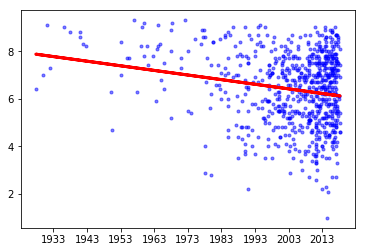

In [19]:
plt.plot(critic_average_test['publication_date'], critic_average_test['critic_average'], 'b.', alpha=0.5)
plt.plot(critic_average_test['publication_date'], critic_average_test['prediction'], 'r-', linewidth=3)
plt.show()

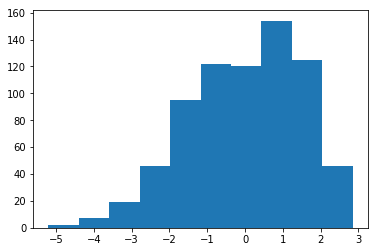

In [20]:
plt.hist(np.subtract(critic_average_test['critic_average'],critic_average_test['prediction']))
plt.show()
#This is close enough to being normal.
#We expect a greater decline on the high end because the average critic rating is higher than the middle rating, 5.

In [21]:
audience_average_test = combined[['publication_date','publication_timestamp','audience_average']].dropna()
fit = stats.linregress(audience_average_test['publication_timestamp'], audience_average_test['audience_average'])
audience_average_test['prediction'] = audience_average_test['publication_timestamp']*fit.slope + fit.intercept
print(fit.pvalue) #p > 0.05, therefore we cannot conclude that the audience ratings are changing.

0.20019655801512012


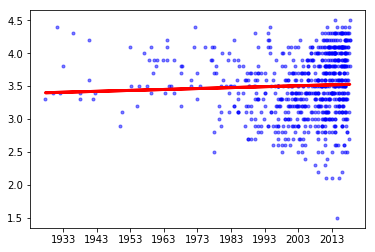

In [22]:
plt.plot(audience_average_test['publication_date'], audience_average_test['audience_average'], 'b.', alpha=0.5)
plt.plot(audience_average_test['publication_date'], audience_average_test['prediction'], 'r-', linewidth=3)
plt.show()

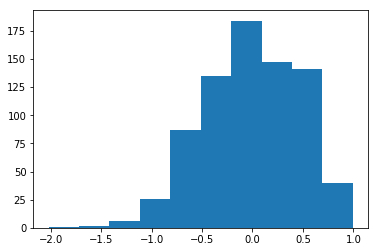

In [23]:
plt.hist(np.subtract(audience_average_test['audience_average'],audience_average_test['prediction']))
plt.show()
#This is close enough to being normal.
#We expect a greater decline on the high end because the average audience rating is higher than the middle rating, 2.5.

# Do average audience ratings change based on its popularity?

In [24]:
audience_ratings_test = combined[['publication_date','publication_timestamp','audience_average','audience_ratings']].dropna()
#Removing movies with n >= 10000000 ratings as they seem like outliers
audience_ratings_test = audience_ratings_test[audience_ratings_test['audience_ratings'] < 10000000]
fit = stats.linregress(audience_ratings_test['audience_ratings'], audience_ratings_test['audience_average'])
audience_ratings_test['prediction'] = audience_ratings_test['audience_ratings']*fit.slope + fit.intercept
print(fit.pvalue) #p < 0.05, therefore we can conclude that higher averages correlate with more popular movies.

0.0003085653249741323


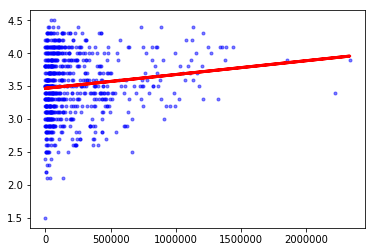

In [25]:
plt.plot(audience_ratings_test['audience_ratings'], audience_ratings_test['audience_average'], 'b.', alpha=0.5)
plt.plot(audience_ratings_test['audience_ratings'], audience_ratings_test['prediction'], 'r-', linewidth=3)
plt.show()

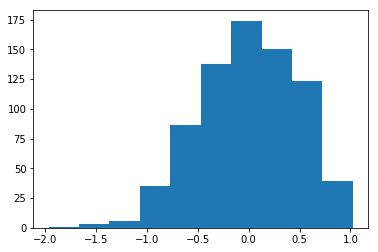

In [26]:
plt.hist(np.subtract(audience_ratings_test['audience_average'],audience_ratings_test['prediction']))
plt.show()
#This is close enough to being normal.
#We expect a greater decline on the high end because the average audience rating is higher than the middle rating, 2.5.

# Does genre have an effect on profitability?

In [88]:
def genre_agg(combined_row):
    for genre_id in combined_row['genre']:
        genre_test.loc[genre_test['wikidata_id'] == genre_id,'total']+=1
        if (combined_row['made_profit'] == 1.0):
            genre_test.loc[genre_test['wikidata_id'] == genre_id,'profit']+=1

In [89]:
genre_test = genres
genre_test['profit'] = 0
genre_test['total'] = 0
combined.apply(genre_agg, axis=1)
genre_test = genre_test[genre_test['total'] > 0]

In [92]:
genre_test['loss'] = genre_test['total'] - genre_test['profit']
contingency = genre_test[['profit','loss']]
contingency = contingency[contingency['profit'] >= 5]
contingency = contingency[contingency['loss'] >= 5]
chi2, p, dof, expected = stats.chi2_contingency(contingency)
print(p) # p < 0.05, therefore genre has some effect on profitability

0.01956332775267009


C:\Users\Matthew\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.
